# Image Classification using Feed-Forward Networks

In this notebook, you will work on a 10-category classification tasks using a keras feed forward networks.
The task will be to use random search to find and evluate a suitable MLP classifier for image classification.

In [18]:
import numpy as np
import seaborn as sns
import pandas as pd
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Dropout
from keras.layers import LeakyReLU
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
sns.set_style("darkgrid")

![title](https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png)

We defined to plotting functions for you which can be used in this (and other) notebooks. The first one plots a confustion matrix. The second one plots the training history.

In [2]:
def plot_cm(y_true, y_pred, classlabels=None,ax=None, xlabel='predicted class',ylabel='actual class',cmtitle='Confusion Matrix'):
    if ax is None:
        fig,ax = plt.subplots()
    conf = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf, annot=True, fmt="d",cmap=sns.color_palette("Blues"),ax=ax)
    if classlabels is not None:
        ax.set(xticklabels=classlabels)
        ax.set(yticklabels=classlabels)
    ax.set(xlabel=xlabel)
    ax.set(ylabel=ylabel)
    ax.set(title=cmtitle)

In [3]:
def plot_model_history(history, ax=None, metric='loss', ep_start=1, ep_stop=None,monitor='val_loss', mode='min',plttitle=None):
    if ax is None:
        fig,ax = plt.subplots()
    if ep_stop is None:
        ep_stop = len(history.epoch)
    if plttitle is None:
        plttitle = metric[0].swapcase() + metric[1:] + ' During Training'
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history[metric][ep_start-1:ep_stop])
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history['val_' + metric][ep_start-1:ep_stop])
    ax.set(title=plttitle)
    ax.set(ylabel=metric[0].swapcase() + metric[1:])
    ax.set(xlabel='Epoch')
    ax.legend(['train', 'val'], loc='upper right')

Ok, lets go! The dataset for this notebook is already included in Keras. To save computational time on small machines we do not use the predefined splits and subsample the data by a factor. 

In [4]:
(X_train, y_train), (X_test,y_test) = cifar10.load_data()
X = np.concatenate((X_train,X_test))
y = np.concatenate((y_train,y_test))
classlabels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog','horse','boat','truck']
#only take a fourth of the dataset, i.e. the first fold
dataset_split = 4
skf = StratifiedKFold(n_splits=dataset_split,shuffle=True,random_state=42)
for train_index, test_index in skf.split(X,y):
    X = X[test_index]
    y = y[test_index]
    break
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.33, random_state=42)

As we can see in this often used dataset, the classes are populated very equal.

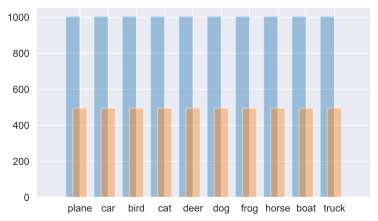

In [5]:
plt.figure(figsize=(6,3.5))
ax = sns.distplot(y_train,kde=False,bins=np.arange(-.5,10,.5))
sns.distplot(y_test+.25,kde=False,bins=np.arange(-.25,10.75,.5), ax=ax)
ax.set(xticks=np.arange(0.5,10))
ax.set(xticklabels=classlabels)
plt.show()

In [6]:
# convert the images to floats between 0 and 1
X_train, X_test = X_train.astype('float32')/255, X_test.astype('float32')/255

__Task:__ Do your desired preprocessing here! Also think about a good representation of your the lables!

In [7]:
# convert the labels to one-hot encoding
print('Before 1 hot coding: ', y_train[5:8].T)
print('Unique labels: ', np.unique(y_train))
(y_train, y_test)=  np_utils.to_categorical(y_train,10), np_utils.to_categorical(y_test,10) #one-hot-encoding
print('After 1 hot coding')
print(y_train[5:8,:])

Before 1 hot coding:  [[7 6 4]]
Unique labels:  [0 1 2 3 4 5 6 7 8 9]
After 1 hot coding
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


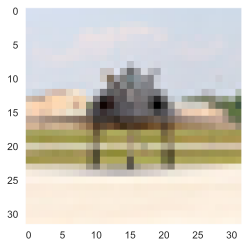

In [8]:
plt.imshow(X_train[0])
plt.grid(False)

Shape of the trainig set:  (10050, 32, 32, 3)
Shape of the mean over the first mode:  (32, 32, 3)


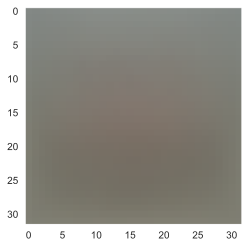

In [9]:
print('Shape of the trainig set: ', X_train.shape)
print('Shape of the mean over the first mode: ', X_train.mean(axis=0).shape)
X_train_mean = np.expand_dims(X_train.mean(axis=0),axis=0)
plt.imshow(X_train_mean[0])
plt.grid(False)
plt.show()

In [10]:
X_train = X_train-X_train_mean
X_test = X_test-X_train_mean

**Task**: Write a build_model function that returns a Keras sequential model suited for 10-class classification (right number of in/outputs). Use only dense layers and keep it at 2-3 hidden layers for now (otherwise computation will take too long). Visualize your model using the `model.summary` and `plot_model()`.

*Hint*: Use `Flatten()` as a first layer, which unfolds the image (3D array) into a vector of pixels.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
hidden1 (Dense)              (None, 2048)              6293504   
_________________________________________________________________
hidden2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 6,557,066
Trainable params: 6,557,066
Non-trainable params: 0
_________________________________________________________________


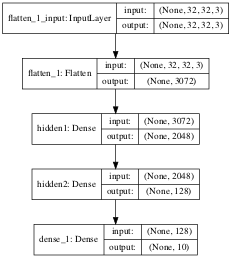

In [11]:
def build_model():
    mlp = Sequential()
    mlp.add(Flatten(input_shape=X_train.shape[1:]))
    mlp.add(Dense(2048,activation='relu',name="hidden1"))
    mlp.add(Dense(128,activation='relu',name="hidden2"))
    mlp.add(Dense(10, activation='softmax'))
    #Compile mlp
    mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return mlp

model = build_model()
model.summary()
plot_model(model, show_shapes=True,show_layer_names=True, dpi=48)

**Task:** Train your "first guess" model on the dataset with early stopping (using a sensible validation split). Plot the accuracy and the loss during the training and a confusion matrix on test and training set. 

In [12]:
from keras.callbacks import EarlyStopping

model = build_model()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.25, epochs=50, batch_size=64, callbacks=[es], verbose=0)

Restoring model weights from the end of the best epoch
Epoch 00011: early stopping


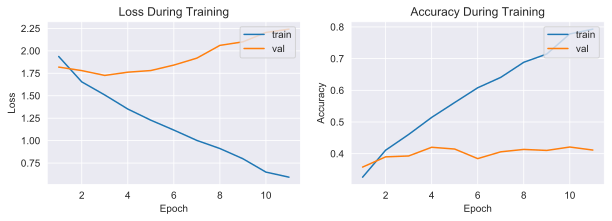

In [13]:
fig, ax = plt.subplots(1,2,figsize=(10,3))
plot_model_history(history, ax=ax[0])
plot_model_history(history, metric='accuracy',ax=ax[1])

4950/4950 [==============================] - 1s 277us/step
[1.7326618402654475, 0.40444445610046387]


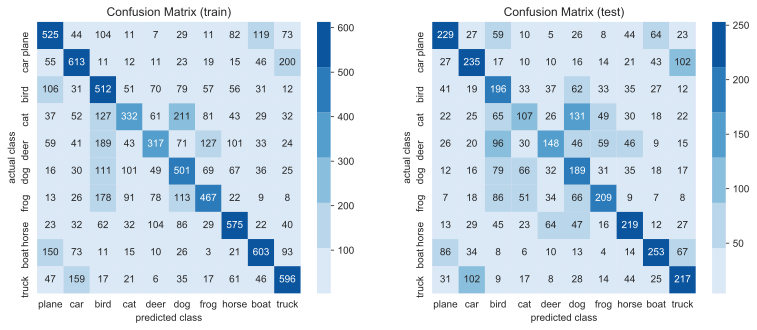

In [14]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print(model.evaluate(X_test,y_test))
fig, ax = plt.subplots(1, 2, figsize=(13,5))
plot_cm(y_train.argmax(axis=1),y_train_pred.argmax(axis=1), ax=ax[0],classlabels=classlabels,cmtitle='Confusion Matrix (train)')
plot_cm(y_test.argmax(axis=1),y_test_pred.argmax(axis=1), ax=ax[1],classlabels=classlabels, cmtitle='Confusion Matrix (test)')

Up to now we only used dense layers, and we did not evaluate different parameters at al. There are a few extra things that could help us.

We ammend our `build_function()` so that it has a size parameter (like in the last notebook), optionally adds dropout before the output layer, and batch normalization after all hidden layers. We also make the activation function a parameter.

_Remark:_ We stick to the _SequentialAPI_ which is not so elegant but easy to understand. We will just use if-else conditions to insert a layer or not.  

In [15]:
from keras.layers import BatchNormalization, Dropout

def build_model(act_fun='relu',size_factor=1,batch_normalize=False,dropout=0):
    mlp = Sequential()
    mlp.add(Flatten(input_shape=X_train.shape[1:]))
    mlp.add(Dense(256*size_factor,activation='relu',name="hidden1"))
    if(batch_normalize):
        mlp.add(BatchNormalization())
        
    mlp.add(Dense(128*size_factor,activation='relu',name="hidden2"))
    if(batch_normalize):
        mlp.add(BatchNormalization())
    
    if(dropout!= 0):
        mlp.add(Dropout(dropout))
        
    mlp.add(Dense(32*size_factor, activation='relu',name="hidden3"))
    if(batch_normalize):
        mlp.add(BatchNormalization())
        
    if(dropout!= 0):
        mlp.add(Dropout(dropout))
        
    mlp.add(Dense(10, activation='softmax'))
    
    #Compile mlp
    mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return mlp

We will now use sklearn routines to try out different parameters. We want to mimic sklearns `RandomizedSearchCV()` [docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) but without cross-validation as this would (for now/using a laptop) take way to long. So we will only use the `ParameterSampler()` [doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterSampler.html?highlight=parametersampler#sklearn.model_selection.ParameterSampler) to randomly draw parameter combinations from our grid. 


**Task:** In the cell below, define a parameter grid of your choice. Setup an ParameterSampler object and chose a number of parameter sets to draw. (Depending on your machine choose a number between 3 and 10.)

In [16]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import ParameterSampler

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4,restore_best_weights=True)
callbacks_list = [es]

estimator = KerasClassifier(build_fn=build_model,verbose=0,size_factor=1,validation_split=0.25 ,act_fun='relu',callbacks=callbacks_list,dropout=False,batch_normalize=False)

param_grid = {'act_fun':['relu','tanh'],
              'batch_normalize' : [False,True],
              'size_factor': [1,2,4],
              'dropout': [0,0.3]}

sampled_params = ParameterSampler(param_grid,8,random_state=42)

Now we can run the models with the given parameters.

_Remark_: We use a pandas dataframe to record the results. This enables us to do the plotting and inspection much easier than with different lists. Furthermore we only keep the best estimator in terms of validation loss.

In [19]:
hist_list = []
val_loss = []
best_val_loss = np.infty
val_acc = []
results=pd.DataFrame()
for i,params in enumerate(sampled_params):
    print("for params:")
    print(params)
    estimator.set_params(**params)
    history = estimator.fit(X_train,y_train,epochs=20, batch_size=64, verbose=0, class_weight=None)
    hist_list.append(history)
    best_ep = np.argmin(history.history['val_loss'])
    val_loss.append(history.history['val_loss'][best_ep])
    val_acc.append(history.history['val_accuracy'][best_ep])
    results = results.append(pd.concat([pd.DataFrame(params,index=[i]), pd.DataFrame({'best_val_loss': history.history['val_loss'][best_ep],
                                                           'best_val_acc': history.history['val_accuracy'][best_ep]},index=[i])],axis=1))
    if history.history['val_loss'][best_ep] < best_val_loss:
        best_est = estimator
        best_val_loss = history.history['val_loss'][best_ep]
        best_idx = i
    print("val_loss = %03f and accuracy is %03f" %(val_loss[-1],val_acc[-1]))

for params:
{'size_factor': 4, 'dropout': 0, 'batch_normalize': True, 'act_fun': 'relu'}
Restoring model weights from the end of the best epoch
Epoch 00007: early stopping
val_loss = 1.705753 and accuracy is 0.406287
for params:
{'size_factor': 2, 'dropout': 0.3, 'batch_normalize': False, 'act_fun': 'tanh'}
Restoring model weights from the end of the best epoch
Epoch 00014: early stopping
val_loss = 1.629191 and accuracy is 0.431357
for params:
{'size_factor': 1, 'dropout': 0, 'batch_normalize': False, 'act_fun': 'relu'}
Restoring model weights from the end of the best epoch
Epoch 00008: early stopping
val_loss = 1.692279 and accuracy is 0.399125
for params:
{'size_factor': 1, 'dropout': 0, 'batch_normalize': True, 'act_fun': 'tanh'}
Restoring model weights from the end of the best epoch
Epoch 00010: early stopping
val_loss = 1.673881 and accuracy is 0.421409
for params:
{'size_factor': 4, 'dropout': 0.3, 'batch_normalize': True, 'act_fun': 'relu'}
Restoring model weights from the end 

_Remark_: We use seabron's `PairGrid()` to get subplots automatically. We just have to submit our dataframe and the variables. We just specify the plot type (barplot in our case) and seaborn is doing the job for us. For each condition the data are grouped according to the x-variables and then the mean value (and confidence interval) of each group is plotted. In terms of loss and mean accuracy we do not see a big difference, this is why we scale the y-axis logarithmically.

<Figure size 432x288 with 0 Axes>

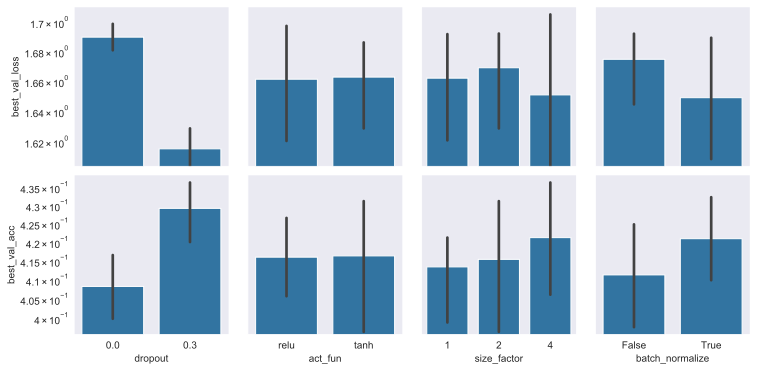

In [20]:
plt.figure()
g = sns.PairGrid(data=results, x_vars=['dropout','act_fun', 'size_factor', 'batch_normalize'], y_vars=['best_val_loss','best_val_acc'])
g.map(sns.barplot)
for ax in g.axes.reshape(-1): 
    ax.set_yscale('log')
plt.show()

**Task**:
Evaluate your best model by plotting confusion matrix. Also have a look at the sklearn [documentation on ROC curves](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) to see if and how you can apply those techniques also in this multiclass problem. Discuss your results (with yourself and your lab book or your friends).

_Remark_: By using `model.predict()` in Keras we get the softmax output, wheareas sklearn wrapped estimators give us the predicted class. If we want to have the softmax "probabilites" we have to call the 'model.predict_proba()' function. For some One-vs-Rest metrics we also compute the one-hot-coded version of the predictions (*y_test/train_pred_mc*)

In [21]:
y_train_pred_proba = best_est.predict_proba(X_train)
y_train_pred = best_est.predict(X_train)
y_test_pred_proba = best_est.predict_proba(X_test)
y_test_pred = best_est.predict(X_test)
y_train_pred_mc = (y_train_pred_proba == y_train_pred_proba.max(axis=1)[:,None]).astype(int)
y_test_pred_mc = (y_test_pred_proba == y_test_pred_proba.max(axis=1)[:,None]).astype(int)

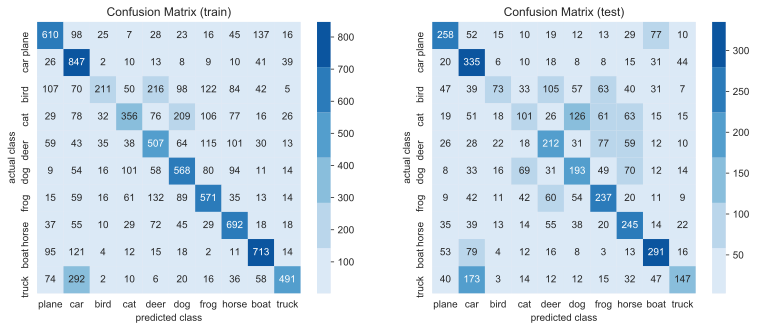

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(13,5))
plot_cm(y_train.argmax(axis=1),y_train_pred, ax=ax[0],classlabels=classlabels,cmtitle='Confusion Matrix (train)')
plot_cm(y_test.argmax(axis=1),y_test_pred, ax=ax[1],classlabels=classlabels, cmtitle='Confusion Matrix (test)')

_Remark_: We now can use the one-hot-coded predictions to easily calculate One-vs-Rest confusion matrices. We could also calculate this quantities directly from the $10 x 10$ confusion matrix from above. 

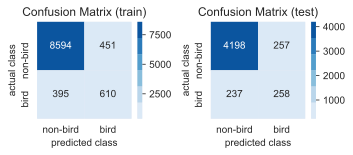

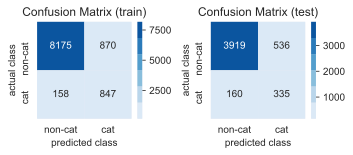

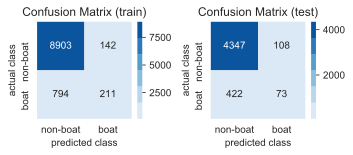

In [23]:
for i,clsnme in enumerate(['bird','cat','boat']):
    fig, ax = plt.subplots(1, 2, figsize=(5,2.25))
    plot_cm(y_train[:,i],y_train_pred_mc[:,i], ax=ax[0],classlabels=['non-'+clsnme,clsnme],cmtitle='Confusion Matrix (train)')
    plot_cm(y_test[:,i],y_test_pred_mc[:,i], ax=ax[1],classlabels=['non-'+clsnme,clsnme], cmtitle='Confusion Matrix (test)')
    plt.tight_layout()

_Remark:_ If we use the model as several One-vs-Rest or One-vs-One classifiers we can in principle also apply metrics based on ROC.

__BUT__: The ROC assumes a decision threshold, by varying this threshold we compute the different FPRs and TPRs to plot the curve. By taking the `argmax()` we do not use a fixed threshold when doing our decision based on the softmax output. So - from the best of my knowledge - it could be _questionable_ to use this multi-class ROC metrics when using argmax in combination with softmax. So it could still be useful to use ROCs but we do not use a fixed threshold. This is why I plotted the FPR and TPR based on argmax-strategy as filled circles.

In [24]:
from sklearn.metrics import roc_auc_score, auc
auc_mc = roc_auc_score(y_test,y_test_pred_proba, average=None, multi_class='ovr',labels=classlabels)
auc_mc

array([0.85701731, 0.87800383, 0.78576835, 0.77640921, 0.81523359,
       0.81477219, 0.87138274, 0.83727647, 0.89762859, 0.85840538])

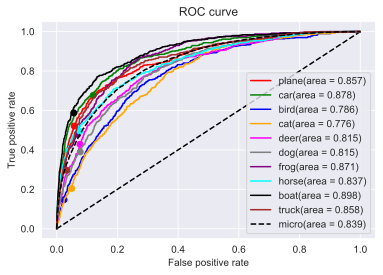

In [25]:
cols = ['red', 'green', 'blue', 'orange', 'magenta', 'grey', 'purple','cyan', 'black', 'brown','black']
fpr = dict()
tpr = dict()
fpr_p = dict()
tpr_p = dict()
thr = dict()
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
for i in range(10):
    fpr[i],tpr[i], thr[i] = roc_curve(y_test[:,i],y_test_pred_proba[:,i])
    fpr_p[i],tpr_p[i],_ = roc_curve(y_test[:,i],y_test_pred_mc[:,i])
    plt.plot(fpr[i], tpr[i],color=cols[i],label=classlabels[i] + '(area = {:.3f})'.format(auc(fpr[i], tpr[i])))
    plt.plot(fpr_p[i][1], tpr_p[i][1],'o',color = cols[i])
fpr['micro'], tpr['micro'], _ = roc_curve(y_test.ravel(), y_test_pred_proba.ravel())
plt.plot(fpr['micro'], tpr['micro'],color=cols[i+1],linestyle='dashed',label='micro' + '(area = {:.3f})'.format(auc(fpr['micro'], tpr['micro'])))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()

_Remark:_ In the following cell we use the code provided in the sklearn docs mentioned above. As we have balanced classes we can see that for the macro average and the weighted macro average there is not difference. This would not be the case if the classes would not be equalliy distributed. 
We could also calculate the so called micro average. 
Imagine the following data. You want to calculate an average Precision (TP/(TP+FP))
 
|         |            | Precision  |
| ------------- |:-------------:| -----:|
| Class A      | 1 TP and 1 FP | 0.5 |
| Class B      | 10 TP and 90 FP      |  0.5 |
| Class C | 1 TP and 1 FP      |   0.1 |
| Class D | 1 TP and 1 FP      |   0.5 |


A macro-average will then compute: $\tfrac{0.5+0.1+0.5+0.5}{4}=0.4$ which is the average of the precisions of each class.

A micro-average will compute: $\tfrac{1+10+1+1}{2+100+2+2}=0.123$  which counts the average by taking all FP and TP directly into account. This is more or less the same as the so called _weighted macro average_.

In [26]:
macro_roc_auc_ovo = roc_auc_score(y_test, y_test_pred_proba, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_test_pred_proba, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.839190 (macro),
0.839190 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.839190 (macro),
0.839190 (weighted by prevalence)
